In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
logins = pd.read_json('logins.json')

In [24]:
logins

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [25]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


The Challenge prompt asks for an aggregation based on 15-minute intervals, so I created a count series where the login count = 1 for every observation. I also set the login_time to become the datetime index so I could more easily aggregate.

In [26]:
logins.set_index('login_time', inplace=True)
logins['count'] = 1

In [27]:
resampled_login = logins.resample('15T', label='right').sum()

Text(0.5, 1.0, 'Resampled 15 Minute Login Counts')

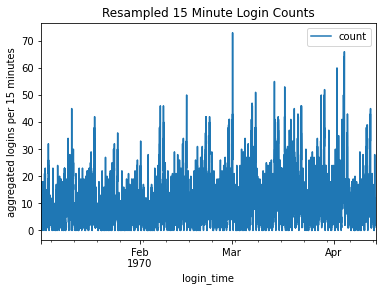

In [28]:

resampled_avg = resampled_login.mean()
resampled_login.plot() #this is for 15 minutes
plt.ylabel('aggregated logins per 15 minutes')
plt.title('Resampled 15 Minute Login Counts')

Text(0.5, 1.0, 'January login by 15-minute aggregation')

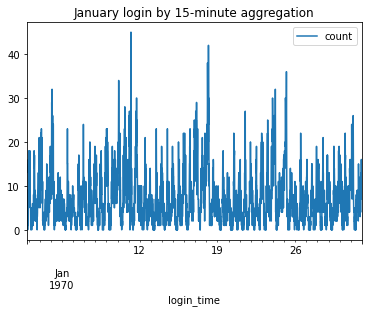

In [98]:
Jan_15_resampled = resampled_login.loc['01-1970']
Jan_15_resampled.plot()
plt.title('January login by 15-minute aggregation')

There seems to be patterns based on the day of the week. Lets bin those days and plot for insight. 

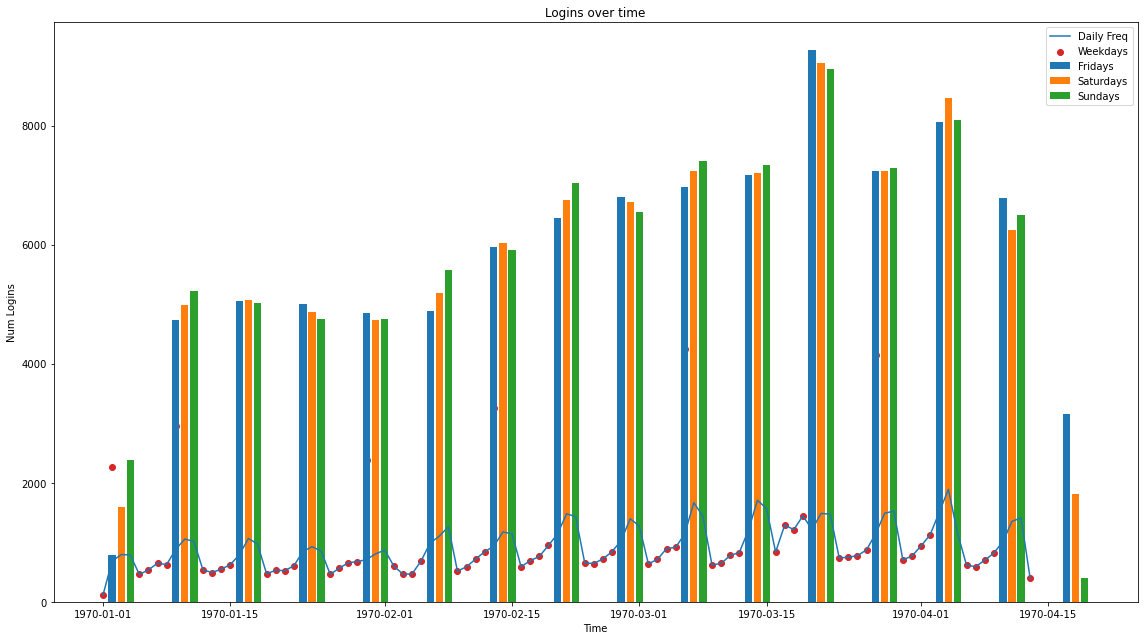

In [32]:
#binning the data
daily_resampled = logins.resample('D').sum()
biz_daily_resampled = logins.resample('B').sum()
fridays_resampled = logins.resample('W-FRI').sum()
saturdays_resampled = logins.resample('W-SAT').sum()
sundays_resampled = logins.resample('W-SUN').sum()

#line, scatter and hist of bins
fig, ax = plt.subplots(figsize=(16,9))

plt.bar(fridays_resampled.index, fridays_resampled['count'], align='center', label='Fridays')
plt.bar(saturdays_resampled.index, saturdays_resampled['count'], align='center', label='Saturdays')
plt.bar(sundays_resampled.index, sundays_resampled['count'], align='center', label='Sundays')
plt.plot(daily_resampled.index, daily_resampled['count'], label='Daily Freq')
plt.scatter(biz_daily_resampled.index, biz_daily_resampled['count'], label='Weekdays')

plt.xlabel('Time')
plt.ylabel('Num Logins')
plt.title('Logins over time')
plt.legend(loc='upper right')
plt.tight_layout()

By focusing in on the monthly logins, there seems to be some sort of seasonal trend (maybe weekly).

,count
login_time,
1970-01-04,"AxesSubplot(0.125,0.125;0.775x0.755)"
1970-01-11,"AxesSubplot(0.125,0.125;0.775x0.755)"
1970-01-18,"AxesSubplot(0.125,0.125;0.775x0.755)"
1970-01-25,"AxesSubplot(0.125,0.125;0.775x0.755)"
1970-02-01,"AxesSubplot(0.125,0.125;0.775x0.755)"


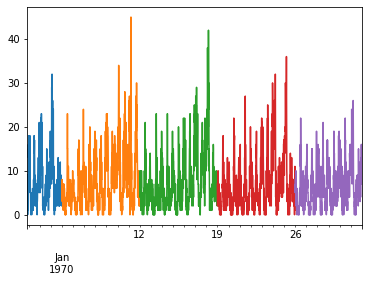

In [115]:
Jan_weekly_resampled= Jan_15_resampled.resample('W')
Jan_weekly_resampled.plot()

# Time Series Considerations:
1. Test for stationarity (ADF)
2. Test for seasonality (ACF)

In [101]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
resampled_ADF = adfuller(resampled_login)
print(resampled_ADF)

(-10.337954309060429, 2.7323966542232807e-18, 38, 9749, {'1%': -3.431020942932955, '5%': -2.8618365160244372, '10%': -2.5669278303551253}, 56368.34584451129)


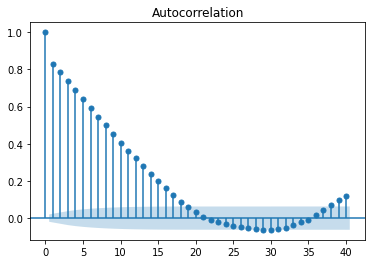

In [129]:
plot_acf(resampled_login, zero=True)
plt.show()

What would happen to the ACF, ADF if I preprocessed using differencing?

In [138]:
resampled_login['diff'] = resampled_login.diff()

In [140]:
resampled_login['diff'].head()

login_time
1970-01-01 20:15:00    NaN
1970-01-01 20:30:00    4.0
1970-01-01 20:45:00    3.0
1970-01-01 21:00:00   -2.0
1970-01-01 21:15:00   -6.0
Freq: 15T, Name: diff, dtype: float64

<AxesSubplot:xlabel='login_time'>

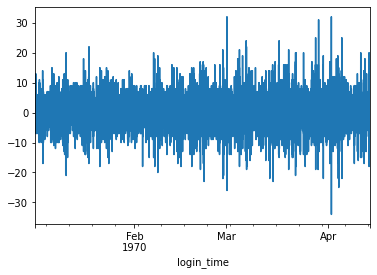

In [143]:
resampled_login['diff'].plot()

In [145]:
adfuller(resampled_login['diff'].dropna())

(-28.87291508084584,
 0.0,
 38,
 9748,
 {'1%': -3.431021011779871,
  '5%': -2.8618365464471562,
  '10%': -2.5669278465492074},
 56467.574602675064)

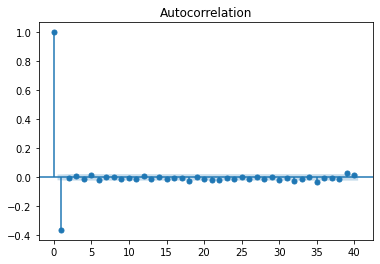

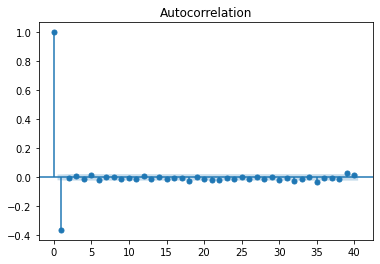

In [148]:
plot_acf(resampled_login['diff'].dropna(), zero=True)

### Differencing yields:
1. More negative ADF score - stronger rejection of H0
2. Visual plot of .diff() time series more in-line with white-noise
3. ACF shows stronger negative correlation at lag=1, but then returns to mean.

# Howabout decomposition? 
## Why decomposition?
### A time series is composed of four parts:
1. Level - the avg value
2. Trend - the increasing/decreasing value in series
3. Seasonality - the repeating short-term cycle
4. Noise - the random variation

### The combination of these four parts can be grouped as:
1. Additive: y(t) = Level+Trend+Seasonality+Noise
2. Multiplicative: y(t) = Level * Trend*Seasonality*Noise

## Key points to remember:
### Additive 
- linear model where changes over time are consistently made by the same amount. Linear seasonality has same frequency and amplitude (width and height of cycles).

### Multiplicative 
- nonlinear (quadratic, exponential) changes increase or decrease over time. Nonlinear seasonality has increasing/decreasing frequency and/or amplitude over time.

#### From the original plot, I determine that this looks more like a multiplicative model

# Back to Decomposition:
### Decomposition provides a structured way of thinking about the time series
#### Specifically, how to capture these four  components in a given model

I will use statmodels.tsa's seasonal_decompose to demonstrate decomposition

In [341]:
from statsmodels.tsa.seasonal import seasonal_decompose

#decomposing original .count series

series = pd.Series(resampled_login['count'])
series_diff = pd.Series(resampled_login['diff'].dropna())

#Note I specified the period param as 16 to demonstrate the 4 weeks of the 4 months = 16
results = seasonal_decompose(series, model='additive', period=resampled_login.shape[0]//4)

#incase you wanted to see the decomposition of the differenced feature
results_diff = seasonal_decompose(series_diff, model='additive', period=resampled_login.shape[0]//4)

## Additive Model Decomposition:

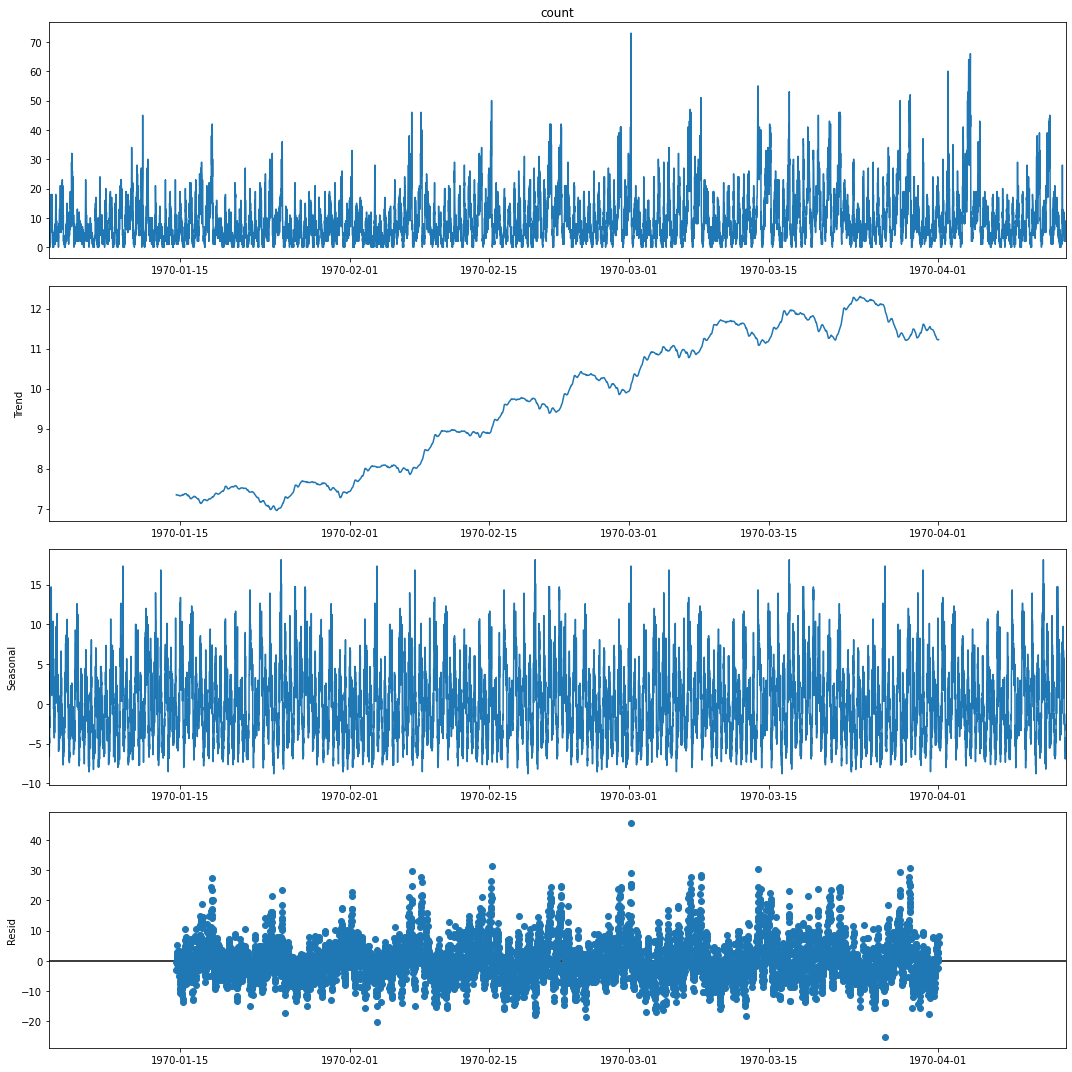

In [339]:
with plt.rc_context():
    plt.rc("figure", figsize=(15,15))
    results.plot()

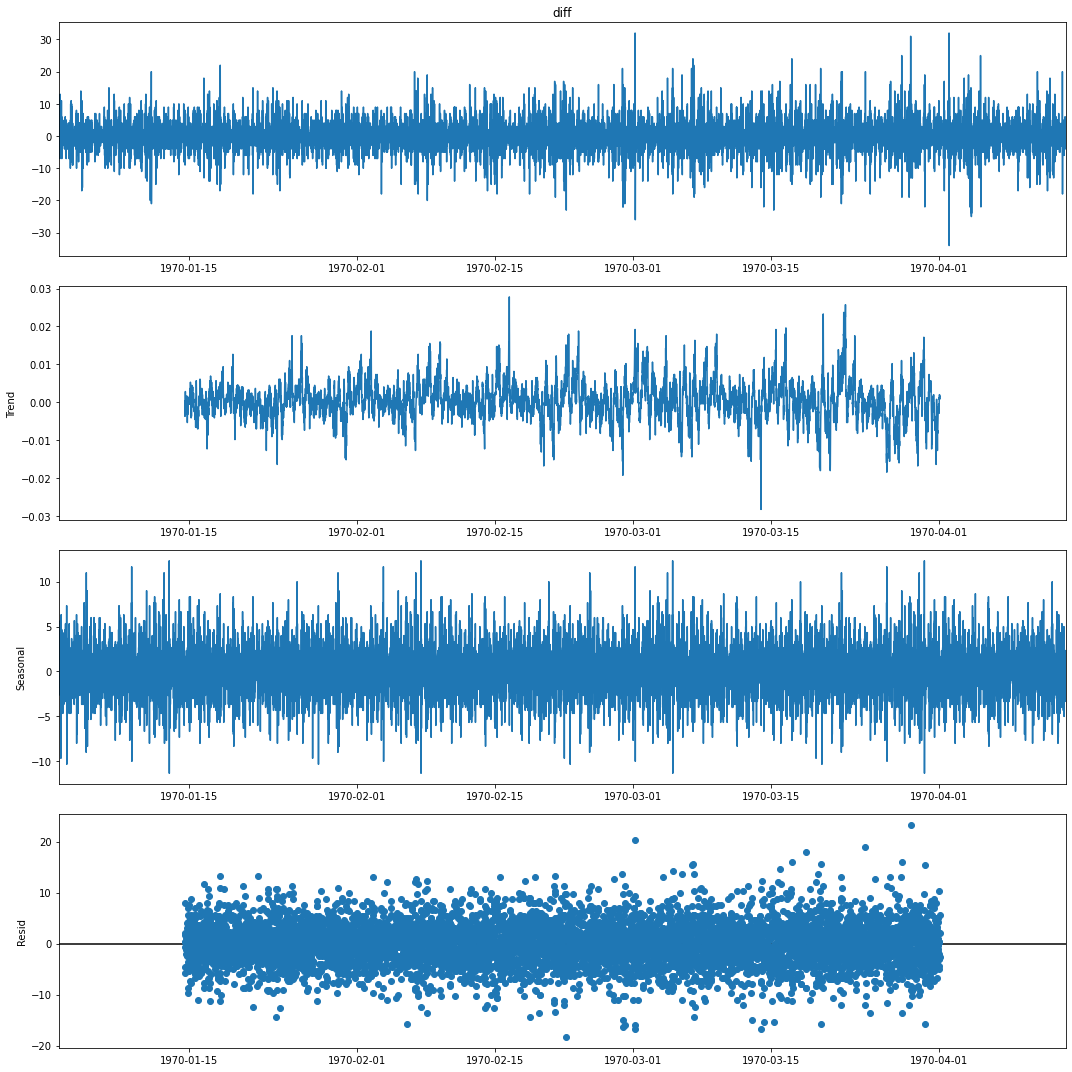

In [342]:
#commenting out - decomposition of the differenced feature
with plt.rc_context():
    plt.rc("figure", figsize=(15,15))
    results_diff.plot()

## Multiplicative Model Decomposition: 

In [192]:
#series.loc[series.values <0].sum()
results_mult = seasonal_decompose(series.drop([x for x in series where x<0],
                                  model='multiplicative', period=resampled_login.shape[0]//4)

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

#### Have to drop all zero values

In [308]:
series1 = pd.Series(resampled_login.loc[~resampled_login['count'].isin([0]), 'count'])


In [309]:
results1 = seasonal_decompose(series1, 
                              model='multiplicative', 
                              period=series1.shape[0]//4)

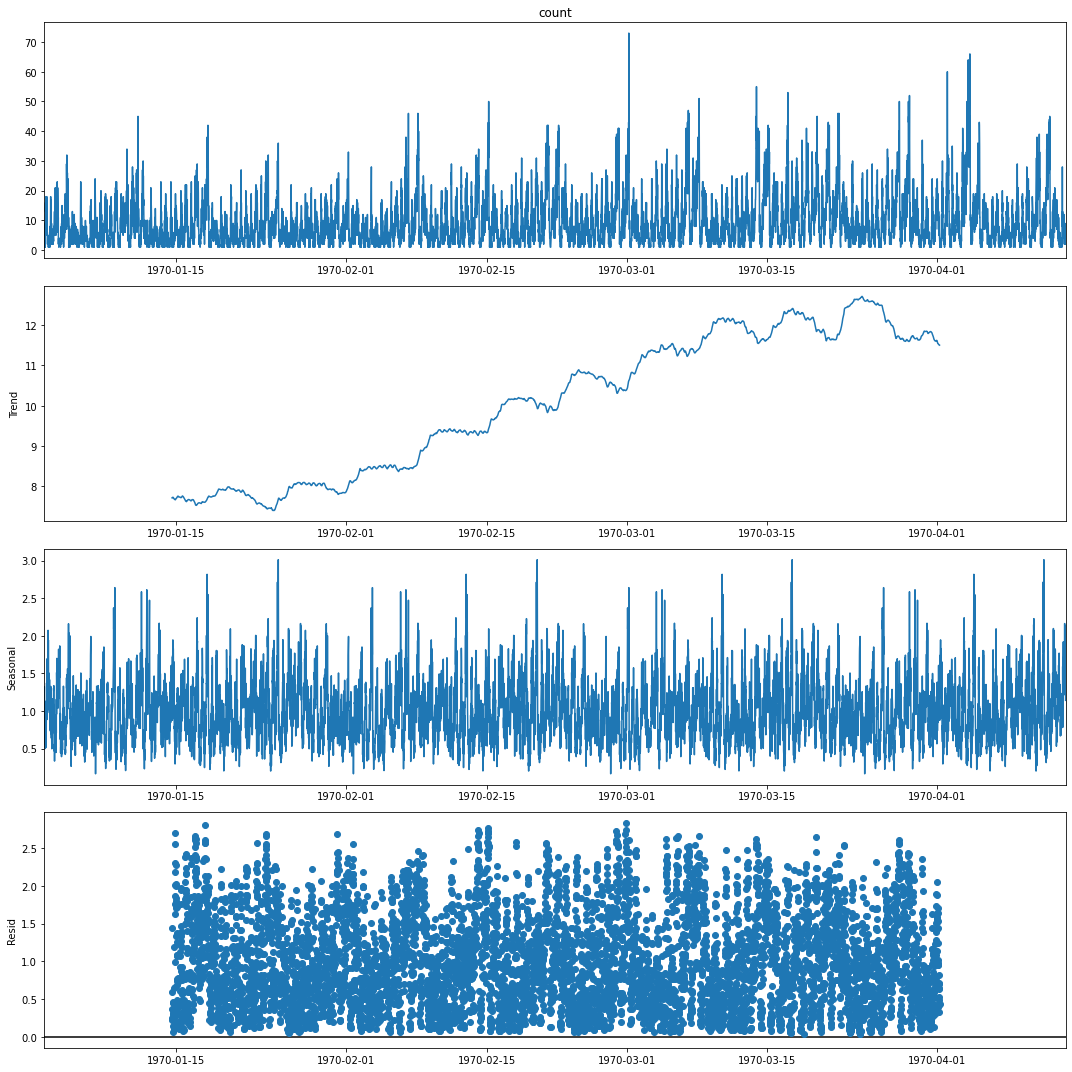

In [310]:
with plt.rc_context():
    plt.rc("figure", figsize=(15,15))
    results1.plot()

# Part 1: EDA Findings
1. This dataset may be a combination of the additive and multiplicative time-series models
2. Decomposed trend (both add and mult) isn't clear cut, not a straight line nor a quadratic or exponential one


# Part 2: Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


### Assumptions:
1. There has to be some sort of mechanism to capture the time of the toll paid.
2. There has to be some sort of mechanism to capture the toll tag id during payment. 
3. There is a record (perhaps binary) to document whether or not the refund was paid.
4. There is a large enough amount of data to apply statistical inference.

### Key measure of success:
To best measure success I would first engineer two utilization ratios. 
For two tollways X, and Y within a defined time frame fitting the experiment's scope I would:
    1. Aggregate the total amount of time a user used either of the two tollways (total_usage)
    2. Create ratio_X, which is the ratio of using tollway X / total_usage
    3. Create ratio_Y, which is the ratio of using tollway Y / total_usage
    
 The logic is for this experiment we want to see a change between the drivers exclusivity. If a driver was exclusive to only toll X, then his ratio_X would be 1, and ratio_Y would be 0. If a driver ever hits parity between the two tolls, we expect both ratios to have values of 0.5.
 
 From there, I could find the difference between the two ratios, with the intent being two-fold:
     1. Binarize 'exclusive' and 'non-exclusive' results. Where exclusive the difference is 1, non-exclusve the diff is any value x where 0 < x < 1
     2. Further explore the strength the non-exclusivity. 
     
I'll call this the ratio_difference. With this value we could determine the prerequisite summary statistics and I'll focus on:
    1. The mean variance
    2. The mean standard deviation
 
 
The statistical experiment depends on the Pearson r - the correlation coefficient -  on the ratio_difference between drivers who were paid a refund, and those who werent to test for significance with the following hypotheses:
    1. H0 - there is not enough evidence to support that the refund affected toll exclusivity
    2. HA - there is sufficient evidence to support the claim that the refund affected exclusivity
    
    
One graphic I would use to help interpret the results of the experiment to the stakeholders would be a distribution graph of ratio_difference. It's intent will be to show the strength of reducing that 'exclusiveness' between the tolls the refund has.

If the correlation coefficient shows a strong correlation, I would continue with performing a chi2 test to see if the difference between the refund and non refund groups are statistically significant.

From there, I would start testing a random forest model for predicting. This would require:

    1. Creating dummy groups for exclusivity
    2. Partitioning the data set for training and test
    3. Tuning parameters to yield best n_estimators
    4. Using the tuned parameter to test
    5. Evaluate the model
    
For the evaluation metrics, if I was only focusing exclusivity, I might consider looking at accuracy, error, and precision.
However if I wanted to focus onthe strength of the exclusivity by looking at ratio_difference, and since that would be a continuous data, I would also pursue the use of RMSE for evaluation. 

# Part 3

In [3]:
ultimate = pd.read_json('ultimate_data_challenge.json')

In [4]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [9]:
ultimate['signup_date'] = pd.to_datetime(ultimate['signup_date'])
ultimate['last_trip_date'] = pd.to_datetime(ultimate['last_trip_date'])

In [10]:
#confirmed features that should be datetime have been converted
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [11]:
ultimate['trips_in_first_30_days']

0         4
1         0
2         3
3         9
4        14
         ..
49995     0
49996     1
49997     0
49998     2
49999     0
Name: trips_in_first_30_days, Length: 50000, dtype: int64

In [12]:
ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [18]:
gotham = ultimate.loc[ultimate['city']=='Gotham', :]

In [22]:
ultimate['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

C:\Users\Aim\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='trips_in_first_30_days', ylabel='Density'>

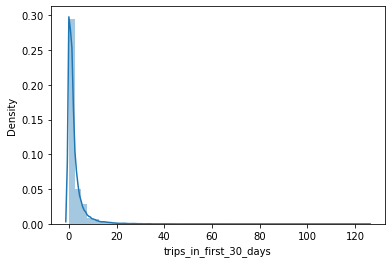

In [16]:
sns.distplot(ultimate['trips_in_first_30_days'])